#/drive/data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os, sys
data_path = '/content/zak04'
try:
    os.symlink('/content/drive/MyDrive/скул/DS/ZAK/zak04', data_path)
    sys.path.insert(0,data_path)
except:
    pass
# Then you can install a library, and specify the target.
# !pip install --target=$data_path vk_api_config.py

Mounted at /content/drive


In [2]:
# @title Generate table

shortcuts = r"""
Action                            Mac         Linux                Windows
Add cursors                       ⌥ ⌘ ↑/↓     Shift Alt ↑/↓        Ctrl Alt ↑/↓
Add cursor on next match          ⌘ D         Ctrl D               Ctrl D
Add cursor on all matches         ⇧ ⌘ L       Shift Ctrl L         Ctrl Shift L
Move line up/down                 ⌥ ↑/↓       Alt ↑/↓              Alt ↑/↓
Copy line up/down                 ⇧ ⌥ ↑/↓     Ctrl Shift Alt ↑/↓   Shift Alt ↑/↓
Delete left                       ⌘ ⌫         Ctrl Backspace       Ctrl Backspace
Delete right                      ⌃ k         (Unset by default)   (Unset by default)
Find with selection               ⌘ E         (Unset by default)   (Unset by default)
Expand/shrink selection           ⇧ ⌃ ⌘ →/←   Shift Alt →/←        Shift Alt →/←
Go to bracket                     ⇧ ⌘ \       Ctrl Shift \         Ctrl Shift \
Replace with next/previous value  ⇧ ⌘ , / .   Ctrl Shift , / .     Ctrl Shift , / .
Transpose letters                 ⌃ T         (Unset by default)   (Unset by default)
"""

import io
import pandas as pd
df = pd.read_csv(io.StringIO(shortcuts), delimiter=' {2,}', engine='python')
df = df.set_index('Action').drop(columns=['Mac'])
df

,Linux,Windows
Action,,
Add cursors,Shift Alt ↑/↓,Ctrl Alt ↑/↓
Add cursor on next match,Ctrl D,Ctrl D
Add cursor on all matches,Shift Ctrl L,Ctrl Shift L
Move line up/down,Alt ↑/↓,Alt ↑/↓
Copy line up/down,Ctrl Shift Alt ↑/↓,Shift Alt ↑/↓
Delete left,Ctrl Backspace,Ctrl Backspace
Delete right,(Unset by default),(Unset by default)
Find with selection,(Unset by default),(Unset by default)
Expand/shrink selection,Shift Alt →/←,Shift Alt →/←


#report

##знакомство с данными.

как было видно из описания, предстояло иметь дело с физико-химическими показателями вин. в качестве выходных данных для каждой представленной партии ожидалось предсказание оценки эксперта, которая основывается только на органолептике. а данных по сорту сырья, бренду, цене нет. указано, что в данных есть пропуски и выбросы.

в дополнительных материалах указана изначальная задача бизнеса в автоматизации процесса классификации вин для дальнейшего определения их ценности и назначения соответствующей цены.

для начала стоило ознакомиться с данными и решить вопросы их качества.
затем создать простую модель, для оценки перспектив работ по улучшению показателей. согласно тому, что в описании оговорено, что задача может быть рассмотрена и как классификационная, и как регрессионная - было решено построить 2 простых линейных модели. после оценки их работы можно было разработать план дальнейших действий.

на начальном этапе было бы полезно поговорить с экспертами в этой области для понимания ценности представленных характеристик в случае необходимости удалять записи. или наоборот, при выборе метода замещения. в крайнем случае, можно попытаться выяснить это по показателям feature importance.

##предобработка

После подсчета количества пропущенных данных выяснилось, что потери по количеству и средним показателям составляют менее 1%, что можно считать несущественными. поэтому строки с пропусками в данных просто отбросили

Затем привели значения во всех графах к числовому виду

#####проверяем на выбросы

для наглядности представим несколько графиков:

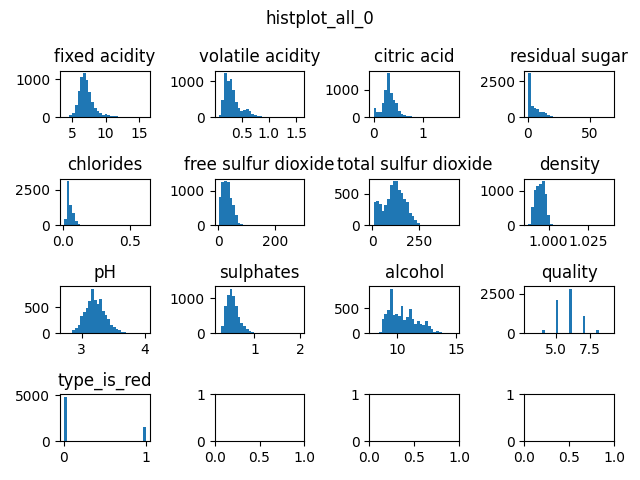

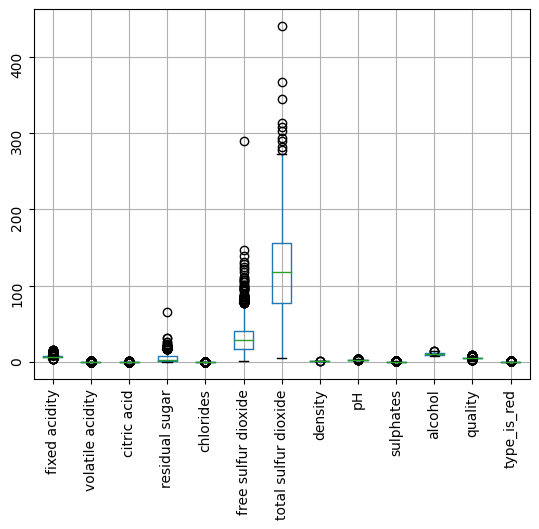

стоит сразу отметить, что данные несбалансированны по выходным классам (график "quality"), что негативно скажется на работе многих моделей (особенно простых)

видно, что основная часть данных по многим показателям сгруппирована в одной стороне графика, а в другой присутствует небольшое количество нехарактерных значений, называемых выбросами. такие данные могут плохо повлиять на обучаемую модель. поэтому стоит понять природу их появления, чтобы учесть в процессе обучения. или же наоборот признать их аномалиями и либо убрать из обучающей выборки, либо заменить какими-либо средними тенденциями.

В ходе исследования не было выявлено тенденции экстремальных значений в признаках ни от качества, ни от типа - характер распределения остается таким же. поэтому приняли решение о признании таких выбросов аномалиями.

остался вопрос пороговых значений, после которых данные считались бы выбросами. установили следующие критерии выбросов для признаков:
- fixed acidity > 12
- volatile acidity > 1
- citric acid > 0.8
- residual sugar > 20
- chlorides > 0.2
- free sulfur dioxide > 100
- total sulfur dioxide > 300
- density > 1.01
- sulphates > 1.1


при таких пороговых значениях, получилось, что потери менее 5%. это весьма незначительно, поэтому приняли решение об удалении записей с такими значениями

данные после удаления выбросов и приведения к стандартному виду выглядят следующим образом:

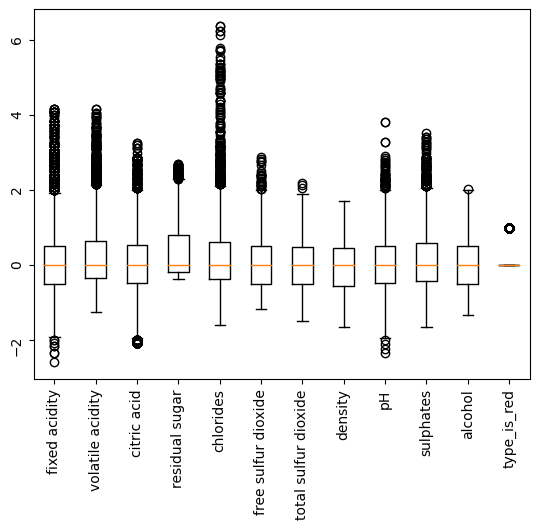

на этом минимальную предобработку закончили, выделили тренировочные и проверочные данные и построили 2 простые линейные модели: классификации и регрессии. для сравнения результатов их работы использовали метрики Accuracy(стандартную для классификации) и взвешенную F1(поскольку классы у нас не сбалансированны). результаты работы регрессионной модели привели к дискретному виду для применения тех же метрик, что и для классификационной модели

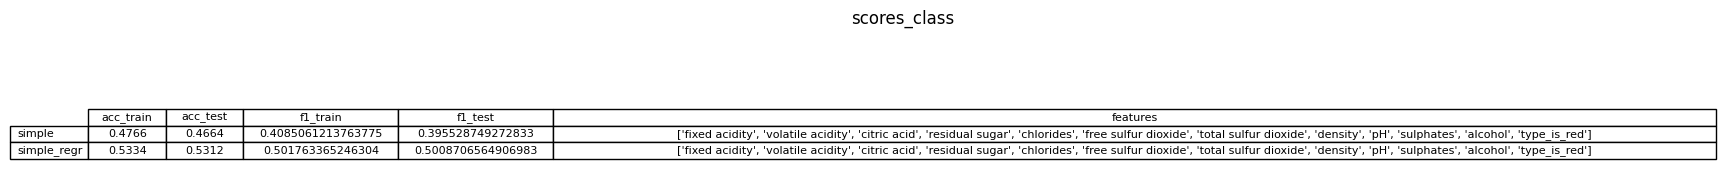

как видно по данным итоговой таблицы - регрессионная модель справилась успешнее.
но в целом результаты обнадёживающие.

для дальнейшей работы есть несколько направлений и методов для проработки:
- пользуясь "подсказкой" из описания, можем разбить датасет по типу вина (красное/белое) и для каждого строить отдельную модель
- можно попробовать ввести полиномные зависимости характеристик
- или наоборот убрать коррелирующие
- в конце концов, можно попробовать более сложные модели, вплоть до нейронных сетей

###Итог

по результатам проведённых начальных исследований видно, что задача в целом решаема. но для получения оптимального результата требует дополнительной обработки данных, проработки многих путей улучшения уже полученных моделей, а может и построения новых. эти пути уже намечены и стоит заняться ими.